In [149]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [150]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [151]:
pip install spacy

In [152]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [153]:
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification

In [ ]:
# Import pre-processed FinBERT data
data = pd.read_csv('df_finbert.csv')

In [200]:
data

,Unnamed: 0,id,quarter,speaker,position,sentence_simple,section
0,169,170,2024Q1,Operator,Operator,open lines question answer session. we will no...,Q&A
1,170,171,2024Q1,Operator,Operator,ask question press star touch tone phone. to a...,Q&A
2,171,172,2024Q1,Operator,Operator,withdraw question press star. to withdraw your...,Q&A
3,172,173,2024Q1,Operator,Operator,pick handset asking question ensure clarity. p...,Q&A
4,173,174,2024Q1,Operator,Operator,streaming today mute computer speakers. if you...,Q&A
...,...,...,...,...,...,...,...
1050,1910,1912,2024Q4,Mark Zuckerberg,CEO,year improvements business going taking AI met...,Q&A
1051,1911,1913,2024Q4,Mark Zuckerberg,CEO,actual business opportunity Meta AI AI Studio ...,Q&A
1052,1912,1914,2024Q4,Mark Zuckerberg,CEO,think important thing communicate people inter...,Q&A
1053,1913,1915,2024Q4,Mark Zuckerberg,CEO,nonetheless we’ ve run a process like this man...,Q&A


Looking at the Q&A section, speeches of Operator and Kenneth Dorell - Director, Investor Relations are not relevant to the analysis. We will remove these speeches from the dataset.

In [201]:
data = data[~data['speaker'].isin(['Operator', 'Kenneth Dorell'])]
df = data.drop(columns=['Unnamed: 0','position','speaker','section'])
df

,id,quarter,sentence_simple
6,176,2024Q1,Thank taking questions. thank you so much for ...
7,177,2024Q1,Mark analogy investment cycles products like S...
8,178,2024Q1,use those analogy how should investor think ab...
9,179,2024Q1,talked impact AI having advertising ecosystem....
10,180,2024Q1,watching terms adoption utility consumer know ...
...,...,...,...
1049,1911,2024Q4,that do not mean that it ’s go to be a major c...
1050,1912,2024Q4,year improvements business going taking AI met...
1051,1913,2024Q4,actual business opportunity Meta AI AI Studio ...
1052,1914,2024Q4,think important thing communicate people inter...


In [202]:
# Import the human annotation data
df_human = pd.read_excel("SC - Human Annotation .xlsx")
df_human = df_human[~df_human['speaker'].isin(['Operator', 'Kenneth Dorell'])]

In [203]:
df_human

,Unnamed: 0,id,quarter,speaker,position,sentence,section,label,Unnamed: 8
6,175,176,2024Q1,Eric Sheridan,Analyst,Thank you so much for taking the questions .,Q&A,0.0,NaN
7,176,177,2024Q1,Eric Sheridan,Analyst,"Mark , you used the analogy of other investmen...",Q&A,0.0,NaN
8,177,178,2024Q1,Eric Sheridan,Analyst,I know you 're not giving long - term guidance...,Q&A,0.0,NaN
9,178,179,2024Q1,Eric Sheridan,Analyst,And you both talked about the impact AI is hav...,Q&A,0.0,NaN
10,179,180,2024Q1,Eric Sheridan,Analyst,What are you watching for in terms of adoption...,Q&A,0.0,NaN
...,...,...,...,...,...,...,...,...,...
1049,1909,1911,2024Q4,Mark Zuckerberg,CEO,But that does nâ€™t mean that it â€™s going to...,Q&A,-1.0,NaN
1050,1910,1912,2024Q4,Mark Zuckerberg,CEO,"This year , the improvements to the business a...",Q&A,1.0,NaN
1051,1911,1913,2024Q4,Mark Zuckerberg,CEO,So the actual business opportunity for Meta AI...,Q&A,0.0,NaN
1052,1912,1914,2024Q4,Mark Zuckerberg,CEO,And I think that â€™s an important thing for u...,Q&A,0.0,NaN


In [204]:
df['label'] = ''
df['label'] = df_human['label'].values

In [205]:
df['label'] = df['label'].map({-1: 2, 0: 0, 1: 1})

In [206]:
df

,id,quarter,sentence_simple,label
6,176,2024Q1,Thank taking questions. thank you so much for ...,0
7,177,2024Q1,Mark analogy investment cycles products like S...,0
8,178,2024Q1,use those analogy how should investor think ab...,0
9,179,2024Q1,talked impact AI having advertising ecosystem....,0
10,180,2024Q1,watching terms adoption utility consumer know ...,0
...,...,...,...,...
1049,1911,2024Q4,that do not mean that it ’s go to be a major c...,2
1050,1912,2024Q4,year improvements business going taking AI met...,1
1051,1913,2024Q4,actual business opportunity Meta AI AI Studio ...,0
1052,1914,2024Q4,think important thing communicate people inter...,0


**Split the dataset into training and test sets. Training set includes the first three quarters of 2024 (about 60% of total dataset)**

In [207]:
train_data = df[df['quarter'].isin(['2024Q1', '2024Q2', '2024Q3'])]
train_data.shape

(592, 4)

In [208]:
test_data = df.drop(train_data.index)
test_data.shape

(382, 4)

In [209]:
train_data

,id,quarter,sentence_simple,label
6,176,2024Q1,Thank taking questions. thank you so much for ...,0
7,177,2024Q1,Mark analogy investment cycles products like S...,0
8,178,2024Q1,use those analogy how should investor think ab...,0
9,179,2024Q1,talked impact AI having advertising ecosystem....,0
10,180,2024Q1,watching terms adoption utility consumer know ...,0
...,...,...,...,...
827,1522,2024Q3,we ’re see good growth in click- to- whatsapp ...,1
828,1523,2024Q3,course lot work Click- to- Messaging ads effec...,1
829,1524,2024Q3,element revenue WhatsApp paid messaging. the o...,0
830,1525,2024Q3,continues grow strong pace quarter. that conti...,1


In [165]:
test_data

,id,quarter,sentence_simple,label
215,575,2025Q1,mark llm landscape continue sort evolv...,1
216,576,2025Q1,sort talk key area advancement focus excited s...,1
217,577,2025Q1,second Meta AI 1 billion user globally. second...,0
218,578,2025Q1,help sort U.S. traction type recur user behavi...,0
219,579,2025Q1,Meta AI usage sure stat share. meta ai usage' ...,2
...,...,...,...,...
1049,1911,2024Q4,that do not mean that it ’s go to be a major c...,2
1050,1912,2024Q4,year improvement business going AI method appl...,1
1051,1913,2024Q4,actual business opportunity Meta AI AI Studio ...,0
1052,1914,2024Q4,think important thing communicate people inter...,0


In the training phase, further divide the training set into training and validation sets with an 70:15:15 split. 

In [210]:
from sklearn.model_selection import train_test_split
df_train, df_temp = train_test_split(train_data, stratify=train_data['label'], test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, stratify=df_temp['label'], test_size=0.5, random_state=42)

- The pre-trained FinBERT from Hugging Face will be fine-tuned on the training set and evaluated on the validation set to select the best model. The final evaluation will be performed on the test set.
- The model yiyanghkust/finbert-tone is chosen from https://huggingface.co/yiyanghkust/finbert-tone

In [ ]:
# Load weights into the model
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3) 
# Split texts into smaller words/subwords and convert them to numbers (input_ids)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [ ]:
%pip install datasets

from datasets import Dataset

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

# Process batches of texts at a time
# Since input_ids have different lengths, and transformers expect them to be in the same length for batch processing, padding tokens ensure all sequences have the same length
# Truncate the sentence to the maximum length accepted by the model
dataset_train = dataset_train.map(lambda x: tokenizer(x['sentence_simple'], padding='max_length', truncation=True, max_length=128), batched=True)
dataset_val = dataset_val.map(lambda x: tokenizer(x['sentence_simple'], padding='max_length', truncation=True, max_length=128), batched=True)
dataset_test = dataset_test.map(lambda x: tokenizer(x['sentence_simple'], padding='max_length', truncation=True, max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 89/89 [00:00<00:00, 709.24 examples/s]


In [214]:
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_auc_score

In [215]:
pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'accelerate": Expected package name at the start of dependency specifier
    'accelerate
    ^


In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_score, recall_score, f1_score

**Training set-up**

In [ ]:
# For classification task, precision, recall and f1-score are used as evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred  # label is the ground truth
    predictions = np.argmax(predictions, axis=1)
    return {'precision': precision_score(labels, predictions, average='macro'),
            'recall': recall_score(labels, predictions, average='macro'),
            'f1': f1_score(labels, predictions, average='macro')}

# Set up hyperparameters in TrainingArguments
# Default hyperparameters are used 
args = TrainingArguments(
    output_dir='temp/', 
    # Report the metrics at the end of every epoch
    eval_strategy='epoch', 
    save_strategy='epoch', 
    logging_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

trainer = Trainer(
    model=finbert,
    args=args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.002000,1.732532,0.897566,0.638426,0.675432
2,0.001400,1.614525,0.903274,0.647685,0.683886
3,0.000100,1.596763,0.903274,0.647685,0.683886


TrainOutput(global_step=78, training_loss=0.0011373769748621644, metrics={'train_runtime': 612.1114, 'train_samples_per_second': 2.029, 'train_steps_per_second': 0.127, 'total_flos': 81696716204544.0, 'train_loss': 0.0011373769748621644, 'epoch': 3.0})

In [237]:
# Validation results
predictions = trainer.predict(dataset_val)
logits = predictions.predictions
labels = predictions.label_ids
metrics = compute_metrics((logits, labels))
print(metrics)

{'precision': 0.9032738095238096, 'recall': 0.6476851851851851, 'f1': 0.6838863750628458}


In [238]:
# Testing results 
finbert.eval()
pre = trainer.predict(dataset_test).predictions
trainer.predict(dataset_test).metrics

{'test_loss': 1.7229384183883667,
 'test_precision': 0.6647058823529411,
 'test_recall': 0.6887755102040817,
 'test_f1': 0.6746512746512746,
 'test_runtime': 9.7669,
 'test_samples_per_second': 9.112,
 'test_steps_per_second': 0.614}

In [ ]:
# Save the model 
trainer.save_model('finbert-sentiment/')

**Apply the fine-tuned FinBERT model on test set**

In [240]:
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [241]:
test_data = test_data.dropna(subset=['sentence_simple'])

In [242]:
prediction_dataset = Dataset.from_pandas(test_data)
prediction_dataset = prediction_dataset.map(lambda x: tokenizer(x['sentence_simple'], padding='max_length', truncation=True, max_length=128), batched=True)
prediction_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 381/381 [00:01<00:00, 360.41 examples/s]


In [243]:
finbert.eval()
pre = trainer.predict(prediction_dataset).predictions
trainer.predict(prediction_dataset).metrics

{'test_loss': 2.0073482990264893,
 'test_precision': 0.6655970698907736,
 'test_recall': 0.6373789313800949,
 'test_f1': 0.6483487064773827,
 'test_runtime': 42.4693,
 'test_samples_per_second': 8.971,
 'test_steps_per_second': 0.565}

In [244]:
predictions = trainer.predict(prediction_dataset)
logits = predictions.predictions
labels = predictions.label_ids
pred_labels = np.argmax(logits, axis=1)
cm = confusion_matrix(labels, pred_labels)

In [245]:
class_names = ["Neutral", "Positive","Negative"]

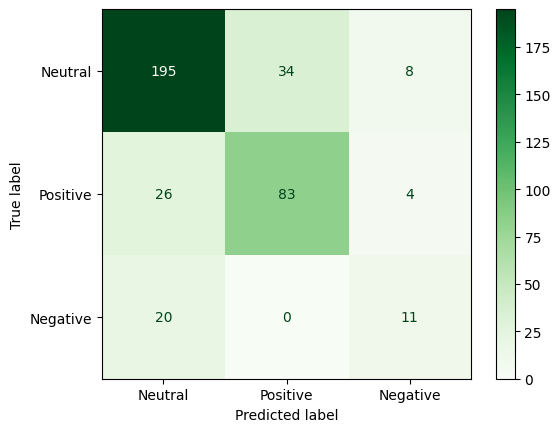

In [246]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(cmap="Greens")

After applying sentiment focus, the test set only contains 381 sentences (instead of 382). This is because there is one sentence in which there is no meaningful phrase before 'partially'

In [247]:
from sklearn.metrics import classification_report
report = classification_report(labels,pred_labels,labels = [0,1,2],target_names=class_names,output_dict=True)
df_report = pd.DataFrame(report).transpose
df_report

<bound method DataFrame.transpose of               Neutral    Positive   Negative  accuracy   macro avg  \
precision    0.809129    0.709402   0.478261   0.75853    0.665597   
recall       0.822785    0.734513   0.354839   0.75853    0.637379   
f1-score     0.815900    0.721739   0.407407   0.75853    0.648349   
support    237.000000  113.000000  31.000000   0.75853  381.000000   

           weighted avg  
precision      0.752630  
recall         0.758530  
f1-score       0.754736  
support      381.000000  >

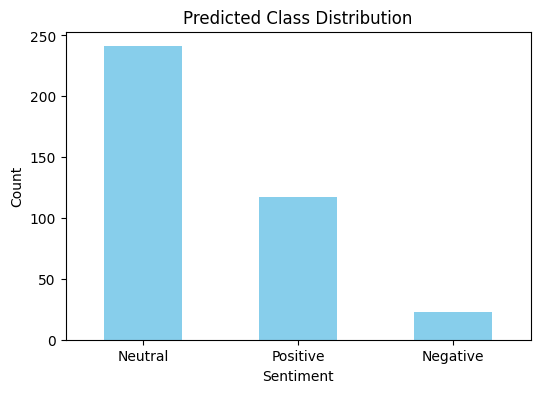

In [248]:
import matplotlib.pyplot as plt
import pandas as pd

# Map numeric class labels to names
class_map = {0: "Neutral", 1: "Positive", 2: "Negative"}

# Count predicted labels
value_counts = pd.Series(pred_labels).value_counts().sort_index()

# Rename index with class names
value_counts.index = value_counts.index.map(class_map)

# Plot histogram
value_counts.plot(kind="bar", figsize=(6,4), color="skyblue")
plt.title("Predicted Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()
